<a href="https://colab.research.google.com/github/Chaarangan/text-classification/blob/main/Text_Classification_Kannada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# And pandas for data import
import pandas as pd

In [ ]:
# Import Files
import os

# Import data from csv
data = pd.read_csv("/tmp/kannada_offensive_train.csv")
data_dev = pd.read_csv("/tmp/kannada_offensive_dev.csv")

# Select required columns
data = data[['text', 'label']]
data_dev = data_dev[['text', 'label']]

# Remove a row if any of the two remaining columns are missing
data = data.dropna();
data_dev = data_dev.dropna()

print(data)
print(data_dev)

                                                   text                                 label
0     Tik tok alli jagala madtidralla adra baggenu o...                         Not_offensive
1                               Anyone from kerala here                           not-Kannada
2                             Movie rerelease madi plss                         Not_offensive
3     Amazon prime alli bittidira....yella manele no...                         Not_offensive
4     Guru sure news nanu tik tok dawn lod madeda ya...                         Not_offensive
...                                                 ...                                   ...
6212                @Gajendra hv neen en maadirodu mele  Offensive_Targeted_Insult_Individual
6213                       Sir neev adthidda game yavdu                         Not_offensive
6214                          Dubb Full movie in telugu                         Not_offensive
6215  Mostly nimma mate keli tic tok ban agirbeku ಅಣ...     

In [ ]:
# copy + klearn because you allways need sklearn
import copy
from sklearn.model_selection import train_test_split

In [ ]:
# Remove rows, where the label is present only ones (can't be split)
data = data.groupby('label').filter(lambda x : len(x) > 1)
data_dev = data_dev.groupby('label').filter(lambda x : len(x) > 1)

# Remove rows, where the label is present only in the array
data = data[data.label.isin(['Not_offensive', 'Offensive_Targeted_Insult_Other', 'Offensive_Targeted_Insult_Individual', 'Offensive_Targeted_Insult_Group', 'not-Kannada', 'Offensive_Untargetede'])]
data_dev = data_dev[data_dev.label.isin(['Not_offensive', 'Offensive_Targeted_Insult_Other', 'Offensive_Targeted_Insult_Individual', 'Offensive_Targeted_Insult_Group', 'not-Kannada', 'Offensive_Untargetede'])]

# Set your model output as categorical and save in new label col
data['label_label'] = pd.Categorical(data['label'])
data_dev['label_label'] = pd.Categorical(data_dev['label'])

# Transform your output to numeric
data['label'] = data['label_label'].cat.codes
data_dev['label'] = data_dev['label_label'].cat.codes

print(data)
print(data_dev)

0                             Not_offensive
1                               not-Kannada
2                               not-Kannada
3                             Not_offensive
4                             Not_offensive
                       ...                 
772                           Not_offensive
773    Offensive_Targeted_Insult_Individual
774                             not-Kannada
775                           Not_offensive
776         Offensive_Targeted_Insult_Group
Name: label_label, Length: 777, dtype: category
Categories (6, object): ['Not_offensive', 'Offensive_Targeted_Insult_Group',
                         'Offensive_Targeted_Insult_Individual', 'Offensive_Targeted_Insult_Other',
                         'Offensive_Untargetede', 'not-Kannada']


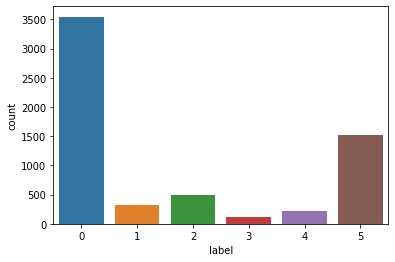

In [ ]:
#Plot the bar chart of Train
import seaborn as sns

sns.countplot(x='label', data=data)

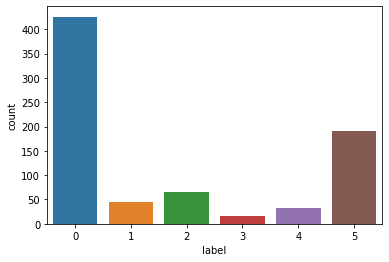

In [ ]:
#Plot the bar chart of Dev
sns.countplot(x='label', data=data_dev)

In [ ]:
# Load Huggingface transformers
!pip install transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
from tensorflow.keras.models import Model

     |████████████████████████████████| 1.5MB 12.2MB/s 
     |████████████████████████████████| 890kB 76.1MB/s 
     |████████████████████████████████| 2.9MB 68.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=82e5cac546a3b64b76b2c354f61f8bc19d865ecbc220cf563659554714777f65
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#Setup BERT

# Name of the BERT model to use
model_name = 'bert-base-multilingual-cased'

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.initializers import TruncatedNormal

In [ ]:
#Build the model 

# Load the MainLayer
bert = transformer_model.layers[0]

# Max length of tokens
max_length = 100

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
label = Dense(units=len(data.label_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='class_type')(pooled_output)
outputs = {'label': label}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='bert-base-multilingual-cased')

# Take a look at the model
model.summary()

Model: "bert-base-multilingual-cased"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 177853440   attention_mask[0][0]             
                                                                 input_ids[0][0]                  
__________________________________________________________________________________________________
pooled_output (Dropout)         (None, 768)          0           bert[0

In [ ]:
#Import Keras Libraries
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [ ]:
#Train the model

# Set an optimizer
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = {'label': CategoricalCrossentropy(from_logits = True)}
metric = {'label': CategoricalAccuracy('accuracy')}

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

# Ready output data for the model
y_label = to_categorical(data['label'])

# Tokenize the input (takes some time)
x = tokenizer(
    text=data['text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids'], 'attention_mask': x['attention_mask']},
    y={'label': y_label},
    validation_split=0.2,
    batch_size=64,
    epochs=50)

model.save("/tmp/text-classification-kannada.h5")

Epoch 1/50
78/78 [==============================] - 79s 799ms/step - loss: 0.3985 - accuracy: 0.8719 - val_loss: 1.3410 - val_accuracy: 0.6905
Epoch 2/50
78/78 [==============================] - 60s 771ms/step - loss: 0.1494 - accuracy: 0.9459 - val_loss: 1.3833 - val_accuracy: 0.6809
Epoch 3/50
78/78 [==============================] - 60s 769ms/step - loss: 0.1304 - accuracy: 0.9525 - val_loss: 1.4373 - val_accuracy: 0.7018
Epoch 4/50
78/78 [==============================] - 60s 771ms/step - loss: 0.0865 - accuracy: 0.9702 - val_loss: 1.4439 - val_accuracy: 0.7251
Epoch 5/50
78/78 [==============================] - 60s 771ms/step - loss: 0.0629 - accuracy: 0.9764 - val_loss: 1.5412 - val_accuracy: 0.6897
Epoch 6/50
78/78 [==============================] - 60s 770ms/step - loss: 0.0478 - accuracy: 0.9816 - val_loss: 1.6064 - val_accuracy: 0.6865
Epoch 7/50
78/78 [==============================] - 60s 770ms/step - loss: 0.0465 - accuracy: 0.9833 - val_loss: 1.5069 - val_accuracy: 0.7114

In [ ]:
#Model 2
# Ready output data for the model
y_label = to_categorical(data_dev['label'])

# Tokenize the input (takes some time)
x = tokenizer(
    text=data_dev['text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids'], 'attention_mask': x['attention_mask']},
    y={'label': y_label},
    validation_split=0.2,
    batch_size=64,
    epochs=50)

Epoch 1/50
10/10 [==============================] - 8s 762ms/step - loss: 1.8133 - accuracy: 0.6957 - val_loss: 1.6933 - val_accuracy: 0.7244
Epoch 2/50
10/10 [==============================] - 8s 758ms/step - loss: 1.6605 - accuracy: 0.7182 - val_loss: 1.5647 - val_accuracy: 0.7308
Epoch 3/50
10/10 [==============================] - 8s 758ms/step - loss: 1.4162 - accuracy: 0.7359 - val_loss: 1.3882 - val_accuracy: 0.7308
Epoch 4/50
10/10 [==============================] - 8s 759ms/step - loss: 1.1474 - accuracy: 0.7649 - val_loss: 1.2515 - val_accuracy: 0.7308
Epoch 5/50
10/10 [==============================] - 8s 758ms/step - loss: 1.0930 - accuracy: 0.7472 - val_loss: 1.1269 - val_accuracy: 0.7115
Epoch 6/50
10/10 [==============================] - 8s 757ms/step - loss: 0.9142 - accuracy: 0.7762 - val_loss: 1.0377 - val_accuracy: 0.7051
Epoch 7/50
10/10 [==============================] - 8s 758ms/step - loss: 0.8291 - accuracy: 0.7794 - val_loss: 0.9939 - val_accuracy: 0.6923
Epoch 

In [ ]:
#Model 3
# Ready output data for the model
y_label = to_categorical(data['label'])

# Tokenize the input (takes some time)
x = tokenizer(
    text=data['text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids'], 'attention_mask': x['attention_mask']},
    y={'label': y_label},
    validation_split=0.2,
    batch_size=64,
    epochs=50)

model.save("/tmp/text-classification-kannada.h5")

Epoch 1/50
78/78 [==============================] - 60s 769ms/step - loss: 0.0227 - accuracy: 0.9895 - val_loss: 1.7509 - val_accuracy: 0.7203
Epoch 2/50
78/78 [==============================] - 60s 768ms/step - loss: 0.0235 - accuracy: 0.9899 - val_loss: 1.7425 - val_accuracy: 0.7211
Epoch 3/50
78/78 [==============================] - 60s 768ms/step - loss: 0.0239 - accuracy: 0.9877 - val_loss: 1.7487 - val_accuracy: 0.7211
Epoch 4/50
78/78 [==============================] - 60s 769ms/step - loss: 0.0233 - accuracy: 0.9887 - val_loss: 1.7385 - val_accuracy: 0.7275
Epoch 5/50
78/78 [==============================] - 60s 768ms/step - loss: 0.0233 - accuracy: 0.9885 - val_loss: 1.7431 - val_accuracy: 0.7291
Epoch 6/50
78/78 [==============================] - 60s 768ms/step - loss: 0.0233 - accuracy: 0.9881 - val_loss: 1.7551 - val_accuracy: 0.7219
Epoch 7/50
78/78 [==============================] - 60s 768ms/step - loss: 0.0237 - accuracy: 0.9883 - val_loss: 1.7622 - val_accuracy: 0.7203

In [ ]:
#Evaluate the model

# Ready test data`
test_y_label = to_categorical(data_dev['label'])
test_x = tokenizer(
    text=data_dev['text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


# Run evaluation
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids'], 'attention_mask': test_x['attention_mask']},
    y={'label': test_y_label}
)

25/25 [==============================] - 3s 130ms/step - loss: 0.5385 - accuracy: 0.8983


In [ ]:
#History object
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
#import matplotlib
from matplotlib import pyplot as plt

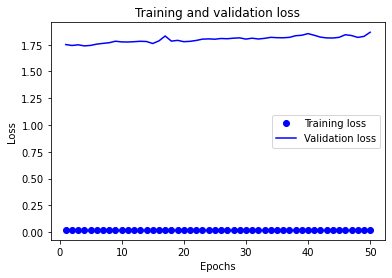

In [ ]:
#plot the training and validation loss for comparison

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

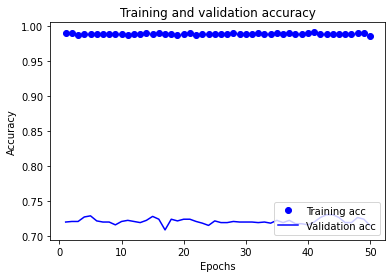

In [ ]:
#plot the training and validation accuracy for comparison
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
#Model Prediction
data_test = pd.read_csv("/tmp/kannada_offensive_test.csv")

# Select required columns
data_test = data_test[['text', 'label']]

# Remove a row if any of the three remaining columns are missing
# data_test = data_test.dropna()

test_x = tokenizer(
    text=data_test['text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

predictions = model.predict({'input_ids': test_x['input_ids'], 'attention_mask': test_x['attention_mask']})
  

In [ ]:
print(len(data_test))
print(len(predictions['label']))

[[ 8.000431  -1.9388584 -2.504746  -2.4236958 -1.3773599 -1.6748071]
 [ 2.8928406 -2.7139034 -3.777966  -1.455674  -2.364487   3.6830022]
 [ 3.0485895 -2.5895681 -3.6256404 -1.785479  -2.2504518  3.417991 ]
 ...
 [ 0.3908304 -2.5767508 -2.7767282 -2.1698864 -2.0237286  7.1196933]
 [ 8.019753  -1.9056973 -2.5773327 -2.4330943 -1.8893183 -1.1985667]
 [ 6.5341578 -1.5068861 -1.1243926 -2.532223   1.3933607 -3.559877 ]]


In [ ]:
#import Numpy
import numpy as np

In [ ]:
#Write out to the csv file
arry = []

data_test = np.array(data_test)
label_array = np.array(predictions['label'])

for i, j in zip(data_test, label_array):
  text = i[0]
  label_value_max = max(j)
  label_index = np.where(label_array == label_value_max)

  labels = ['Not_offensive', 'Offensive_Targeted_Insult_Group', 'Offensive_Targeted_Insult_Individual', 'Offensive_Targeted_Insult_Other', 'Offensive_Untargetede', 'not-Kannada']
  arry.append([text, labels[label_index[1][0]]])
  # print(i[0] + i[1] + ' - ' + labels[label_index[1][0]])


pre = pd.DataFrame(arry, columns=['text', 'label'])
pre.to_csv('/tmp/prediction-kannada.csv')

In [ ]:
from google.colab import files
files.download('/tmp/text-classification-kannada.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>